In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import glob
from os import path

In [2]:
%matplotlib inline

In [3]:
!ls data/NYT/

NYT_bicultural.json	     NYT_multicultural.json
NYT_biethnic.json	     NYT_multiethnic.json
NYT_biracial.json	     NYT_multiracial.json
NYT_cultural_pluralism.json  NYT_other ethnicity.json
NYT_interracial.json	     NYT_other race.json
NYT_mixed ethnicity.json     NYT_polyculturalism.json
NYT_mixed_race.json	     NYT_polycultural.json
NYT_monocultural.json	     NYT_polyethnic.json
NYT_monoracial.json	     NYT_polyracial.json
NYT_multiculturalism.json


In [4]:
obj = json.load(open("data/NYT/NYT_bicultural.json"))
df = pd.DataFrame.from_records(obj["graph_data"][0]["data"])
df = df.rename(columns={"total_articles_published": "Total"})
database = df[["Total", "year"]]

for file in glob.glob("data/NYT/*json"):
  obj = json.load(open(file))
  word = path.basename(file).split("_", 1)[1].split(".")[0]
  print(word)
  df = pd.DataFrame.from_records(obj["graph_data"][0]["data"])
  df.drop("total_articles_published", 1, inplace=True)
  df = df.rename(columns={"article_matches": word})
  database = pd.merge(database, df, on="year", how="outer")

database.set_index("year", inplace=True)
values = (database.values.T / database.Total.values).T
values[:, 0] = database.Total.values
database_norm = pd.DataFrame(data=values, columns=database.columns, index=database.index)

mixed_race
other ethnicity
multiethnic
interracial
polyracial
monoracial
polycultural
other race
biethnic
multicultural
bicultural
multiculturalism
multiracial
mixed ethnicity
polyethnic
cultural_pluralism
monocultural
biracial
polyculturalism


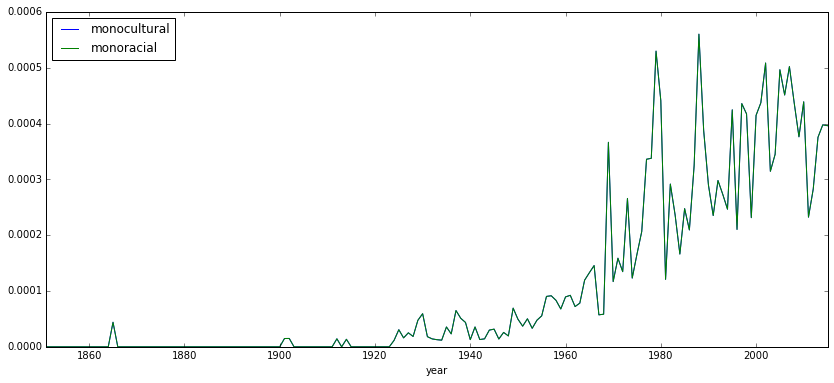

In [5]:
_ = database_norm[['monocultural', 'monoracial']].plot(figsize=(14,6))

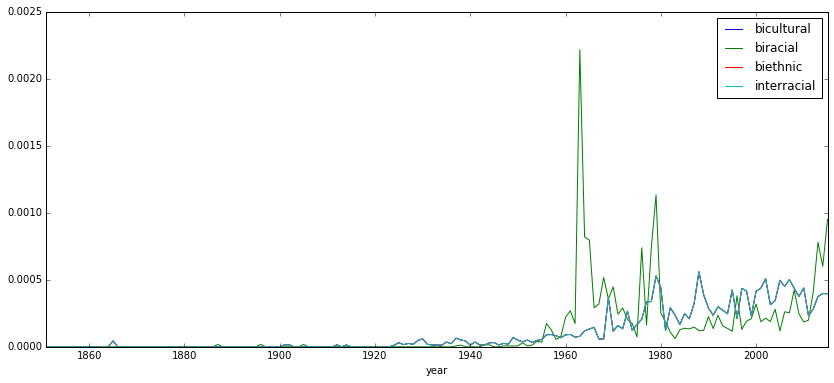

In [6]:
_ = database_norm[['bicultural', 'biracial', 'biethnic', 'interracial']].plot(figsize=(14,6))

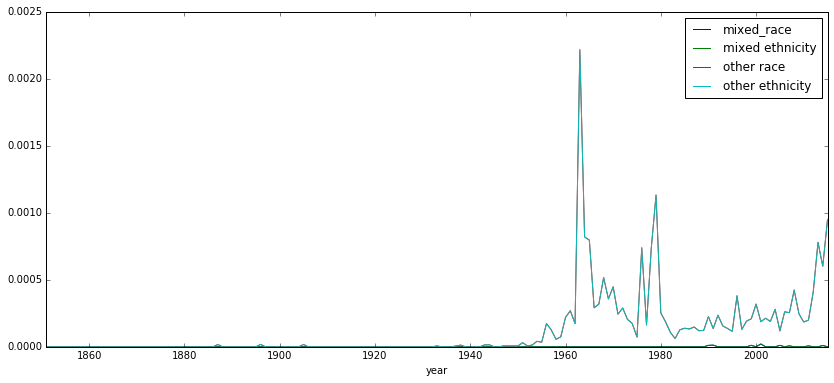

In [7]:
_ = database_norm[['mixed_race', 'mixed ethnicity', 'other race', 'other ethnicity']].plot(figsize=(14,6))

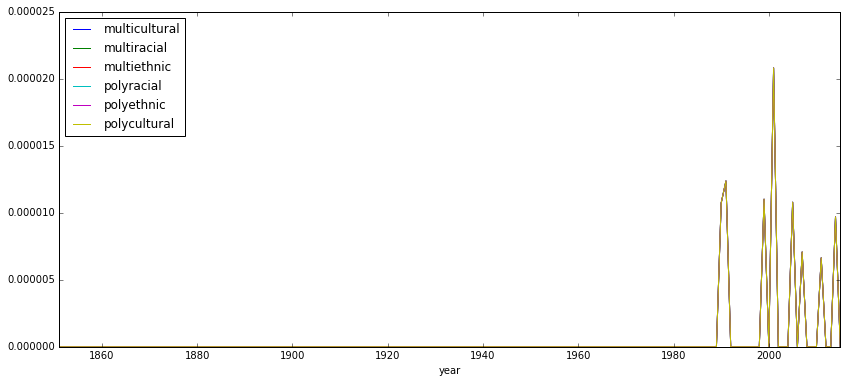

In [8]:
_ = database_norm[['multicultural', 'multiracial', 'multiethnic', 'polyracial', 'polyethnic', 'polycultural']].plot(figsize=(14,6))

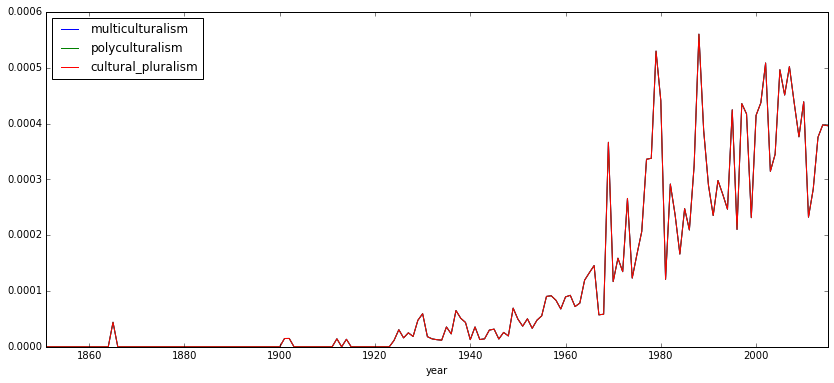

In [9]:
_ = database_norm[['multiculturalism', 'polyculturalism', 'cultural_pluralism']].plot(figsize=(14,6))

polyculturalism has no frequency in NYT

# To Do

1. Fix data 
1. Smoothen lines
1. Key: top left -- NYT (dashed line), Google Books 